In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, MaxPooling2D, Conv2D, Flatten
from keras.optimizers import Adam
from keras import regularizers
from keras import optimizers
from keras import initializers
from keras.preprocessing import image

import keras.backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.patches as patches

Using TensorFlow backend.


In [2]:
# Read images
images = np.zeros((710,260,400))

for i in range(480):
    filename = 'dataOpenedEye/openedEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    images[i] = img

for i in range(81):
    filename = 'dataPavel/pavelEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    images[i+480] = img   
    
for i in range(74):
    filename = 'dataYannick/yannickEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    images[i+480+81] = img   

for i in range(75):
    filename = 'dataKevin/kevinEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    images[i+480+81+74] = img    
    
images = np.reshape(images, (images.shape[0], images.shape[1], images.shape[2], 1))

# Rescale images
images = images/255.

images.shape

(710, 260, 400, 1)

In [3]:
# Read target values
target1 = pd.read_csv('dataOpenedEye/dataPupilCenter.csv')
target2 = pd.read_csv('dataPavel/pavelPupilCenter.csv')
target3 = pd.read_csv('dataYannick/yannickPupilCenter.csv')
target4 = pd.read_csv('dataKevin/kevinPupilCenter.csv')
target = [target1, target2, target3, target4]
target = pd.concat(target)

target.shape

(710, 3)

In [4]:
# Remove missing values
images = images[target.xcentral != '?']
target = target[target.xcentral != '?']
target = target.astype('float32')
target.shape

(676, 3)

In [5]:
# Put target data in shape
targetX = target['xcentral'].values.reshape((target['xcentral'].shape[0], 1))
targetY = target['ycentral'].values.reshape((target['ycentral'].shape[0], 1))

# Rescale targets between 0 and 1 
targetX = targetX/400.
targetY = targetY/260.

targetTrain = np.concatenate((targetX, targetY), axis=1)
targetTrain.shape

(676, 2)

In [6]:
# Data augmentation by adding horizontal mirror images
imagesFlipped = np.flip(images, axis=2)

targetFlipped = np.zeros(targetTrain.shape)
targetFlipped[:,0] = 1-targetTrain[:,0]
targetFlipped[:,1] = targetTrain[:,1]

images = np.concatenate((images, imagesFlipped), axis=0)
targetTrain = np.concatenate((targetTrain, targetFlipped), axis=0)

<IPython.core.display.Javascript object>


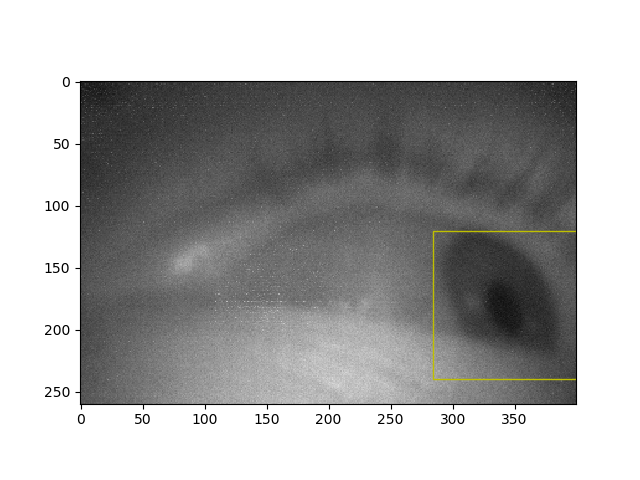

In [7]:
%matplotlib notebook
# Image to display
index=1176

display = np.reshape(images[index], (260,400))
box = targetTrain[index]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(display, cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((box[0]*400-60,box[1]*260-60),120,120,linewidth=1,edgecolor='y',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [8]:
# Shuffle data
xtrain, ytrain = shuffle(images, targetTrain, random_state=0)
#xvalid = xtrain[512:]
#xtrain = xtrain[:512]
#yvalid = ytrain[512:]
#ytrain = ytrain[:512]

In [9]:
def model(Xshape):
    
    mod = Sequential()
    mod.add(Conv2D(4, (7, 7), activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.0), input_shape=Xshape))
    mod.add(MaxPooling2D(pool_size=(4, 4)))
    
    mod.add(Conv2D(8, (7, 7), activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.0)))
    mod.add(MaxPooling2D(pool_size=(4, 4)))

    mod.add(Flatten())
#    mod.add(Dense(256, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
    mod.add(Dense(128, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.02)))
#    mod.add(Dense(256, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.0)))
    mod.add(Dense(2, activation='sigmoid', kernel_initializer='glorot_normal'))
    
    return mod

In [10]:
mymodel = model(xtrain.shape[1:])
opt = optimizers.Adam(lr=0.0001)
mymodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
# First train with small mini batch size and default learning rate
mymodel.fit(xtrain, ytrain, epochs = 40, batch_size=64)

Epoch 1/40
1352/1352 [==============================] - 55s 40ms/step - loss: 2.0283 - acc: 0.6220
Epoch 2/40
1352/1352 [==============================] - 54s 40ms/step - loss: 0.3348 - acc: 0.6642
Epoch 3/40
1352/1352 [==============================] - 54s 40ms/step - loss: 0.0551 - acc: 0.8062
Epoch 4/40
1352/1352 [==============================] - 55s 40ms/step - loss: 0.0227 - acc: 0.8395
Epoch 5/40
1352/1352 [==============================] - 55s 40ms/step - loss: 0.0175 - acc: 0.8765
Epoch 6/40
1352/1352 [==============================] - 54s 40ms/step - loss: 0.0163 - acc: 0.8558
Epoch 7/40
1352/1352 [==============================] - 54s 40ms/step - loss: 0.0162 - acc: 0.8661
Epoch 8/40
1352/1352 [==============================] - 54s 40ms/step - loss: 0.0146 - acc: 0.8846
Epoch 9/40
1352/1352 [==============================] - 54s 40ms/step - loss: 0.0141 - acc: 0.8550
Epoch 10/40
1352/1352 [==============================] - 54s 40ms/step - loss: 0.0121 - acc: 0.8876
Epoch 11/

In [ ]:
# Then train with smaller learning rate and larger batch size
K.set_value(mymodel.optimizer.lr, 0.0005)
mymodel.fit(xtrain, ytrain, epochs = 10, batch_size=128)
K.set_value(mymodel.optimizer.lr, 0.0001)
mymodel.fit(xtrain, ytrain, epochs = 10, batch_size=256)

In [ ]:
# Make the prediction on all
ypredict = mymodel.predict(images)

In [ ]:
#%matplotlib notebook
index=1100

display = np.reshape(images[index], (260,400))
box = ypredict[index]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(display, cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((box[0]*400-60,box[1]*260-60),120,120,linewidth=1,edgecolor='y',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [ ]:
# Make the prediction for valid dataset
validPredict = mymodel.predict(xvalid)

In [ ]:
index=14

display = np.reshape(xvalid[index], (260,400))
box = validPredict[index]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(display, cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((box[0]*400-60,box[1]*260-60),120,120,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [ ]:
# Make the prediction on a totally new dataset
# Read images
newImages = np.zeros((216,260,400))

for i in range(216):
    filename = 'dataAli/aliEye'+str(i)+'.jpg'
    img=mpimg.imread(filename)
    newImages[i] = img

        
newImages = np.reshape(newImages, (newImages.shape[0], newImages.shape[1], newImages.shape[2], 1))

# Rescale images
newImages = newImages/255.

# Make the prediction for valid dataset
newImagesPredict = mymodel.predict(newImages)

In [ ]:
# Image to display
index=100

display = np.reshape(newImages[index], (260,400))
box = newImagesPredict[index]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(display, cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((box[0]*400-60,box[1]*260-60),120,120,linewidth=1,edgecolor='y',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()
